# introduction 
<p>
    Dans cette partie on s'interesse à la façon d'extraire de l'information à partir de la structure des phrase:
    ici on faire des etudes statistique sur les partie d'une phrase à savoir  les noms, verbes, les pronons etc 
</p>

# Définition des fonctions utiles :

# intialisation et lecture de données

In [0]:
import pandas as pd
import re
import numpy as np
from collections import Counter
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from functools import reduce

## utilses MLFlow

In [90]:
pip install mlflow

In [0]:
from mlflow.entities import Param, Metric, RunTag
import mlflow 
def set_experiment(experiment_name):
    mlflow.set_experiment(experiment_name);
    step = 1;

def save (metrics, tags):
    client  = mlflow.tracking.MlflowClient();
    with mlflow.start_run() as run :
        client.log_batch(run_id=run.info.run_uuid,metrics=metrics,tags=tags);

## Utilses confusion matrix

In [0]:
import seaborn as sn
import matplotlib.pyplot as plt

def plot_confusion_matrix(matrix, labels):
    df_cm = pd.DataFrame(matrix, index = labels,columns = labels)
    plt.figure(figsize = (12,10))
    sn.heatmap(df_cm, annot=True)

## Utiles Models

In [0]:
from sklearn.model_selection import cross_val_score
import time
from sklearn.metrics import confusion_matrix

In [0]:
from sklearn.linear_model import LogisticRegression

def logisticRegression (X,y,X_test,y_test,data_tag):
    tags = [RunTag("model_type","Logistic Regression"),RunTag("data",data_tag)]

    clf = LogisticRegression()
    clf.fit(X,y)

    scores = cross_val_score(clf,X,y,scoring="accuracy",cv=20)
    cv_score = np.mean(scores)

    score = clf.score(X_test,y_test) 
    now = int(time.time()+.5)
    confmat  = confusion_matrix(y_test,clf.predict(X_test),labels=y_test.unique())
    plot_confusion_matrix(confmat,y_test.unique())
    metrics = [Metric(key="cross_val_accuracy",value=cv_score,timestamp=now,step=1),Metric(key="test_accuracy",value=score,timestamp=now,step=1)] 
    save(metrics,tags)

In [0]:
from sklearn.linear_model import SGDClassifier

def sGDClassifier(X,y,X_test,y_test,data_tag):
    tags = [RunTag("model_type","SGDClassifier"),RunTag("data",data_tag)]

    clf = SGDClassifier()
    clf.fit(X,y)

    scores = cross_val_score(clf,X,y,scoring="accuracy",cv=20)
    cv_score = np.mean(scores)

    score = clf.score(X_test,y_test) 
    now = int(time.time()+.5)
    
    confmat  = confusion_matrix(y_test,clf.predict(X_test),labels=y_test.unique())
    plot_confusion_matrix(confmat,y_test.unique())
    
    metrics = [Metric(key="cross_val_accuracy",value=cv_score,timestamp=now,step=1),Metric(key="test_accuracy",value=score,timestamp=now,step=1)] 
    save(metrics,tags)


In [0]:
from sklearn.linear_model import PassiveAggressiveClassifier

def passiveAggressiveClassifier(X,y,X_test,y_test,data_tag):
    tags = [RunTag("model_type","Passivd Agressive Classifier"),RunTag("data",data_tag)]
    
    clf = PassiveAggressiveClassifier()
    clf.fit(X,y)

    scores = cross_val_score(clf,X,y,scoring="accuracy",cv=20)
    cv_score = np.mean(scores)

    score = clf.score(X_test,y_test) 
    now = int(time.time()+.5)
    
    confmat  = confusion_matrix(y_test,clf.predict(X_test),labels=y_test.unique())
    plot_confusion_matrix(confmat,y_test.unique())
    
    metrics = [Metric(key="cross_val_accuracy",value=cv_score,timestamp=now,step=1),Metric(key="test_accuracy",value=score,timestamp=now,step=1)] 
    save(metrics,tags)

In [0]:
from sklearn.svm import LinearSVC
    
def linearSVC(X,y,X_test,y_test,data_tag):
    tags = [RunTag("model_type","SVM LinearSVC"),RunTag("data",data_tag)]

    clf = LinearSVC()
    clf.fit(X,y)

    scores = cross_val_score(clf,X,y,scoring="accuracy",cv=20)
    cv_score = np.mean(scores)

    score = clf.score(X_test,y_test) 
    now = int(time.time()+.5)
    
    confmat  = confusion_matrix(y_test,clf.predict(X_test),labels=y_test.unique())
    plot_confusion_matrix(confmat,y_test.unique())
    
    metrics = [Metric(key="cross_val_accuracy",value=cv_score,timestamp=now,step=1),Metric(key="test_accuracy",value=score,timestamp=now,step=1)] 
    save(metrics,tags)

# Chargement des données 

In [98]:
#from google.colab import files
#uploaded = files.upload()

Saving train_prepared.csv to train_prepared (2).csv


In [0]:
data = pd.read_csv("../data.csv")
#data = pd.read_csv("train_prepared.csv")

In [0]:
#data=data.rename(columns={"TEXTE resulted":"TEXTE_resulted"})

In [0]:
nlp = spacy.load("en_core_web_sm");
# ajouter 
tokens = list()
sentences = list()

for text in data.text:
    doc = nlp(text)
    t = list();
    for token in doc :
        t.append((token.text, token.lemma_, token.pos_, token.dep_,token.shape_, token.is_alpha, token.is_stop))
    tokens.append(t);
    t = list();
    for sent in doc.sents :
        t.append(sent)
    sentences.append(t)

# tokenization + sentences 
data.insert(2,"tokens",tokens)
data.insert(3,"sentences",sentences) 

In [0]:
train, test = train_test_split (data,test_size=1100,random_state=14)

# Sentence Part 1

In [0]:
class Vectorizer :
    def __init__(self,groupby="lang"):
        self.SUMMARY = None;
        self.COLUMNS = list();
        
    def fit(self,x):
        self.SUMMARY = x.groupby("lang").agg(["min","max","mean","median","std"]);
        
    def transform(self,x):
        # je parcoure la metrics 
        index  = self.SUMMARY.index.values
        columns = self.SUMMARY.columns
        matrix = list()
        for item in x :
            vector = list()
            for l in index:
                # lecture des five number summary pour le langue L
                min =    self.SUMMARY.loc[l][columns[0]];
                max =    self.SUMMARY.loc[l][columns[1]];
                mean =   self.SUMMARY.loc[l][columns[2]];
                median = self.SUMMARY.loc[l][columns[3]];
                std =    self.SUMMARY.loc[l][columns[4]];
                # calcul des distacnes (Norme1, Norme2) par rapport au min
                min_1 = self.norme_1(min,item);
                self.COLUMNS.append(l+"_"+columns[0][0]+"_min_dest_1");
                vector.append(min_1);
                min_2 = self.norme_2(min,item);
                self.COLUMNS.append(l+"_"+columns[0][0]+"_min_dest_2");
                vector.append(min_2);
                # calcul des distacnes (Norme1, Norme2) par rapport au max
                max_1 = self.norme_1(max,item);
                self.COLUMNS.append(l+"_"+columns[0][0]+"_max_dest_1");
                vector.append(max_1);
                max_2 = self.norme_2(max,item);
                self.COLUMNS.append(l+"_"+columns[0][0]+"_max_dest_2");
                vector.append(max_2);
                # calcul des distacnes (Norme1, Norme2) par rapport au moyenne
                mean_1 = self.norme_1(mean,item);
                self.COLUMNS.append(l+"_"+columns[0][0]+"_mean_dest_1");
                vector.append(mean_1);
                mean_2 = self.norme_2(mean,item);
                self.COLUMNS.append(l+"_"+columns[0][0]+"_mean_dest_2");
                vector.append(mean_2);
                # calcul des distacnes (Norme1, Norme2) par rapport au mediane
                median_1 = self.norme_1(median,item);
                self.COLUMNS.append(l+"_"+columns[0][0]+"_median_dest_1");
                vector.append(median_1);
                median_2 = self.norme_2(median,item);
                self.COLUMNS.append(l+"_"+columns[0][0]+"_median_dest_2");
                vector.append(median_2);
                # calcul des distacnes (Norme1, Norme2) par rapport à l'écart-type 
                std_1 = mean_1/std;
                self.COLUMNS.append(l+"_"+columns[0][0]+"_std_dest_1")
                vector.append(std_1);
                std_2 = mean_2/std;
                self.COLUMNS.append(l+"_"+columns[0][0]+"_std_dest_2")
                vector.append(std_2);
            matrix.append(vector)
        return np.array(matrix);
                
    def norme_2 (self,ref,val):
        return np.sqrt((ref-val)**2);

    def norme_1 (self,ref,val):
        return np.abs(ref-val);
        
    def get_summary(self):
        return self.SUMMARY;
    
    def get_columns(self):
        return np.unique(self.COLUMNS);  

## 1- extraction de la ponctuation (PUNCT)

In [115]:
# transformation train
punct_train = train.tokens.map(lambda x : [(w[0]) for w in x if w[2] == "PUNCT"])

punct_train_count_semi_col=train["lang"].str.count(";", re.I)
punct_train_count_camma=train["lang"].str.count(",", re.I)
punct_train_count_point=train["lang"].str.count("\.", re.I)
punct_train_count_two_point=train["lang"].str.count(":", re.I)
punct_train_count_exclamation=train["lang"].str.count("\!", re.I)
punct_train_count_interogation=train["lang"].str.count("\?", re.I)
punct_train_count_cannot=train["lang"].str.count("cannot", re.I)
punct_train_count_can_not=train["lang"].str.count("can not", re.I)

#erreurs grammaticales liees a la ponctuation (le package me permettant d'identifier les erreurs grammaticales j'ai recode certaines erreurs)
Grammar_camma_err=train["lang"].str.count("[a-z]*. \,", re.I)
Grammar_point_err=train["lang"].str.count("[a-z]*. \.", re.I)
Grammar_interogation_err=train["lang"].str.count("[a-z]*. \?", re.I)
Grammar_exclamation_err=train["lang"].str.count("[a-z]*. \!", re.I)
Grammar_semi_coll_err=train["lang"].str.count("[a-z]*. \;", re.I)
Grammar_parentese_open_err=train["lang"].str.count("[a-z]*. \(", re.I)
Grammar_parentese_close_err=train["lang"].str.count("[a-z]*. \)", re.I)


cnt_punct_train = punct_train.apply(lambda x : len(x))
train.insert(4,"CNT_punct",cnt_punct_train)
#columns added 
train.insert(5,"CNT_punct_camma",punct_train_count_camma)
train.insert(6,"CNT_punct_point",punct_train_count_point)
train.insert(7,"CNT_punct_two_point",punct_train_count_two_point)
train.insert(8,"CNT_punct_count_exclamation",punct_train_count_exclamation)
train.insert(9,"CNT_punct_count_interogation",punct_train_count_interogation)
train.insert(10,"CNT_count_cannot",punct_train_count_cannot)
train.insert(11,"CNT_count_can_not",punct_train_count_can_not)

train.insert(12,"CNT_Grammar_camma_err",Grammar_camma_err)
train.insert(13,"CNT_Grammar_point_err",Grammar_point_err)
train.insert(14,"CNT_Grammar_interogation_err",Grammar_interogation_err)
train.insert(15,"CNT_Grammar_exclamation_err",Grammar_exclamation_err)
train.insert(16,"CNT_Grammar_semi_coll_err",Grammar_semi_coll_err)
train.insert(17,"CNT_Grammar_parentese_open_err",Grammar_parentese_open_err)
train.insert(18,"CNT_Grammar_parentese_close_err",Grammar_parentese_close_err)


# transformation test
punct_test = test.tokens.map(lambda x : [(w[0]) for w in x if w[2] == "PUNCT"])
punct_test_count_semi_col=test["lang"].str.count(";", re.I)
punct_test_count_camma=test["lang"].str.count(",", re.I)
punct_test_count_point=test["lang"].str.count(".", re.I)
punct_test_count_two_point=test["lang"].str.count(":", re.I)
punct_test_count_exclamation=test["lang"].str.count("\!", re.I)
punct_test_count_interogation=test["lang"].str.count("\?", re.I)
punct_test_count_cannot=test["lang"].str.count("cannot", re.I)
punct_test_count_can_not=test["lang"].str.count("can not", re.I)

#erreurs grammaticales liees a la ponctuation (le package me permettant d'identifier les erreurs grammaticales j'ai recode certaines erreurs)
Grammar_test_camma_err=test["lang"].str.count("[a-z]*. \,", re.I)
Grammar_test_point_err=test["lang"].str.count("[a-z]*. \.", re.I)
Grammar_test_interogation_err=test["lang"].str.count("[a-z]*. \?", re.I)
Grammar_test_exclamation_err=test["lang"].str.count("[a-z]*. \!", re.I)
Grammar_test_semi_coll_err=test["lang"].str.count("[a-z]*. \;", re.I)
Grammar_test_parentese_open_err=test["lang"].str.count("[a-z]*. \(", re.I)
Grammar_test_parentese_close_err=test["lang"].str.count("[a-z]*. \)", re.I)

cnt_punct_test = punct_test.apply(lambda x : len(x))
test.insert(4,"CNT_punct",cnt_punct_test)
#columns added 
test.insert(5,"CNT_punct_camma",punct_test_count_camma)
test.insert(6,"CNT_punct_point",punct_test_count_point)
test.insert(7,"CNT_punct_two_point",punct_test_count_two_point)
test.insert(8,"CNT_punct_count_exclamation",punct_test_count_exclamation)
test.insert(9,"CNT_punct_count_interogation",punct_test_count_interogation)
test.insert(10,"CNT_count_cannot",punct_test_count_cannot)
test.insert(11,"CNT_count_can_not",punct_test_count_can_not)

test.insert(12,"CNT_Grammar_camma_err",Grammar_test_camma_err)
test.insert(13,"CNT_Grammar_point_err",Grammar_test_point_err)
test.insert(14,"CNT_Grammar_interogation_err",Grammar_test_interogation_err)
test.insert(15,"CNT_Grammar_exclamation_err",Grammar_test_exclamation_err)
test.insert(16,"CNT_Grammar_semi_coll_err",Grammar_test_semi_coll_err)
test.insert(17,"CNT_Grammar_parentese_open_err",Grammar_test_parentese_open_err)
test.insert(18,"CNT_Grammar_parentese_close_err",Grammar_test_parentese_close_err)

# vectorisation 
punct_vectorizer = Vectorizer();
punct_vectorizer.fit(train[["Labele","CNT_punct","CNT_punct_camma","CNT_punct_point","CNT_punct_two_point","CNT_punct_count_exclamation",
                            "CNT_punct_count_interogation","CNT_count_cannot","CNT_count_can_not","CNT_Grammar_camma_err","CNT_Grammar_point_err",
                            "CNT_Grammar_interogation_err","CNT_Grammar_exclamation_err","CNT_Grammar_semi_coll_err","CNT_Grammar_parentese_open_err",
                            "CNT_Grammar_parentese_close_err"]]);

punct_matrix_train = pd.DataFrame(punct_vectorizer.transform(train.CNT_punct))
punct_matrix_train.columns = ["punct_"+str(i) for i in punct_matrix_train.columns]

punct_matrix_test = pd.DataFrame(punct_vectorizer.transform(test.CNT_punct))
punct_matrix_test.columns = ["punct_"+str(i) for i in punct_matrix_test.columns]

<input>:6: DeprecationWarning: invalid escape sequence \.
<input>:6: DeprecationWarning: invalid escape sequence \.
<input>:6: DeprecationWarning: invalid escape sequence \.
<input>:6: DeprecationWarning: invalid escape sequence \.
<input>:6: DeprecationWarning: invalid escape sequence \.
<input>:6: DeprecationWarning: invalid escape sequence \.
<input>:6: DeprecationWarning: invalid escape sequence \.
<input>:8: DeprecationWarning: invalid escape sequence \!
<input>:6: DeprecationWarning: invalid escape sequence \.
<input>:8: DeprecationWarning: invalid escape sequence \!
<input>:6: DeprecationWarning: invalid escape sequence \.
<input>:8: DeprecationWarning: invalid escape sequence \!
<input>:6: DeprecationWarning: invalid escape sequence \.
<input>:8: DeprecationWarning: invalid escape sequence \!
<input>:9: DeprecationWarning: invalid escape sequence \?
<input>:6: DeprecationWarning: invalid escape sequence \.
<input>:8: DeprecationWarning: invalid escape sequence \!
<input>:9: Dep

In [118]:
test.columns

Index(['Labele', 'TEXTE_resulted', 'tokens', 'sentences', 'CNT_punct',
       'CNT_punct_camma', 'CNT_punct_point', 'CNT_punct_two_point',
       'CNT_punct_count_exclamation', 'CNT_punct_count_interogation',
       'CNT_count_cannot', 'CNT_count_can_not', 'CNT_Grammar_camma_err',
       'CNT_Grammar_point_err', 'CNT_Grammar_interogation_err',
       'CNT_Grammar_exclamation_err', 'CNT_Grammar_semi_coll_err',
       'CNT_Grammar_parentese_open_err', 'CNT_Grammar_parentese_close_err'],
      dtype='object')

## 2- extraction des verbes CNT_verb (VERB)

In [42]:
verb_train = train.tokens.map(lambda x : [(w[0]) for w in x if w[2] == "VERB"])
cnt_verb_train = verb_train.apply(lambda x : len(x))
train.insert(4,"CNT_verb",cnt_verb_train)

# transformation test
verb_test = test.tokens.map(lambda x : [(w[0]) for w in x if w[2] == "VERB"])
cnt_verb_test = verb_test.apply(lambda x : len(x))
test.insert(4,"CNT_verb",cnt_verb_test)

# vectorisation 
verb_vectorizer = Vectorizer();
verb_vectorizer.fit(train[["Labele","CNT_verb"]]);

verb_matrix_train = pd.DataFrame(verb_vectorizer.transform(train.CNT_verb))
verb_matrix_train.columns = ["verb_"+str(i) for i in verb_matrix_train.columns]

verb_matrix_test = pd.DataFrame(verb_vectorizer.transform(test.CNT_verb))
verb_matrix_test.columns = ["verb_"+str(i) for i in verb_matrix_test.columns]

ValueError: ignored

## 3- extraction des adjectifs CNT_adj (ADJ)

In [0]:
# transformation train
adj_train = train.tokens.map(lambda x : [(w[0]) for w in x if w[2] == "ADJ"])
cnt_adj_train = adj_train.apply(lambda x : len(x))
train.insert(4,"CNT_adj",cnt_adj_train)

# transformation test
adj_test = test.tokens.map(lambda x : [(w[0]) for w in x if w[2] == "ADJ"])
cnt_adj_test = adj_test.apply(lambda x : len(x))
test.insert(4,"CNT_adj",cnt_adj_test)

# vectorisation 
adj_vectorizer = Vectorizer();
adj_vectorizer.fit(train[["lang","CNT_adj"]]);

adj_matrix_train = pd.DataFrame(adj_vectorizer.transform(train.CNT_adj))
adj_matrix_train.columns = ["adj_"+str(i) for i in adj_matrix_train.columns]

adj_matrix_test = pd.DataFrame(adj_vectorizer.transform(test.CNT_adj))
adj_matrix_test.columns = ["adj_"+str(i) for i in adj_matrix_test.columns]

## 4- extraction des Pornom CNT_pronom (PRON)

In [0]:
# transformation train
pron_train = train.tokens.map(lambda x : [(w[0]) for w in x if w[2] == "PRON"])
cnt_pron_train = pron_train.apply(lambda x : len(x))
train.insert(4,"CNT_pron",cnt_pron_train)

# transformation test
pron_test = test.tokens.map(lambda x : [(w[0]) for w in x if w[2] == "PRON"])
cnt_pron_test = pron_test.apply(lambda x : len(x))
test.insert(4,"CNT_pron",cnt_pron_test)

# vectorisation 
pron_vectorizer = Vectorizer();
pron_vectorizer.fit(train[["lang","CNT_pron"]]);

pron_matrix_train = pd.DataFrame(pron_vectorizer.transform(train.CNT_pron))
pron_matrix_train.columns = ["pron_"+str(i) for i in pron_matrix_train.columns]

pron_matrix_test = pd.DataFrame(pron_vectorizer.transform(test.CNT_pron))
pron_matrix_test.columns = ["pron_"+str(i) for i in pron_matrix_test.columns]

## 5 - extraction des Nom (NOUN)

In [0]:
# transformation train
nom_train = train.tokens.map(lambda x : [(w[0]) for w in x if w[2] == "NOUN"])
cnt_nom_train = nom_train.apply(lambda x : len(x))
train.insert(4,"CNT_nom",cnt_nom_train)

# transformation test
nom_test = test.tokens.map(lambda x : [(w[0]) for w in x if w[2] == "NOUN"])
cnt_nom_test = nom_test.apply(lambda x : len(x))
test.insert(4,"CNT_nom",cnt_nom_test)

# vectorisation 
nom_vectorizer = Vectorizer();
nom_vectorizer.fit(train[["lang","CNT_nom"]]);

nom_matrix_train = pd.DataFrame(nom_vectorizer.transform(train.CNT_nom))
nom_matrix_train.columns = ["nom_"+str(i) for i in nom_matrix_train.columns]

nom_matrix_test = pd.DataFrame(nom_vectorizer.transform(test.CNT_nom))
nom_matrix_test.columns = ["nom_"+str(i) for i in nom_matrix_test.columns]

## 6 - extraction des Auxiliaire (AUX)

In [0]:
# transformation train
aux_train = train.tokens.map(lambda x : [(w[0]) for w in x if w[2] == "AUX"])
cnt_aux_train = aux_train.apply(lambda x : len(x))
train.insert(4,"CNT_aux",cnt_aux_train)

# transformation test
aux_test = test.tokens.map(lambda x : [(w[0]) for w in x if w[2] == "AUX"])
cnt_aux_test = aux_test.apply(lambda x : len(x))
test.insert(4,"CNT_aux",cnt_aux_test)

# vectorisation 
aux_vectorizer = Vectorizer();
aux_vectorizer.fit(train[["lang","CNT_aux"]]);

aux_matrix_train = pd.DataFrame(aux_vectorizer.transform(train.CNT_aux))
aux_matrix_train.columns = ["aux_"+str(i) for i in aux_matrix_train.columns]

aux_matrix_test = pd.DataFrame(aux_vectorizer.transform(test.CNT_aux))
aux_matrix_test.columns = ["aux_"+str(i) for i in aux_matrix_test.columns]

## 7 - extraction des conjonction de coordination (CCONJ)

In [0]:
# transformation train
cconj_train = train.tokens.map(lambda x : [(w[0]) for w in x if w[2] == "CCONJ"])
cnt_cconj_train = cconj_train.apply(lambda x : len(x))
train.insert(4,"CNT_cconj",cnt_cconj_train)

# transformation test
cconj_test = test.tokens.map(lambda x : [(w[0]) for w in x if w[2] == "CCONJ"])
cnt_cconj_test = cconj_test.apply(lambda x : len(x))
test.insert(4,"CNT_cconj",cnt_cconj_test)

# vectorisation 
cconj_vectorizer = Vectorizer();
cconj_vectorizer.fit(train[["lang","CNT_cconj"]]);

cconj_matrix_train = pd.DataFrame(cconj_vectorizer.transform(train.CNT_cconj))
cconj_matrix_train.columns = ["cconj_"+str(i) for i in cconj_matrix_train.columns]

cconj_matrix_test = pd.DataFrame(cconj_vectorizer.transform(test.CNT_cconj))
cconj_matrix_test.columns = ["cconj_"+str(i) for i in cconj_matrix_test.columns]

## 8 - extraction des DETerminants (DET)

In [0]:
# transformation train
det_train = train.tokens.map(lambda x : [(w[0]) for w in x if w[2] == "DET"])
cnt_det_train = det_train.apply(lambda x : len(x))
train.insert(4,"CNT_det",cnt_det_train)

# transformation test
det_test = test.tokens.map(lambda x : [(w[0]) for w in x if w[2] == "DET"])
cnt_det_test = det_test.apply(lambda x : len(x))
test.insert(4,"CNT_det",cnt_det_test)

# vectorisation 
det_vectorizer = Vectorizer();
det_vectorizer.fit(train[["lang","CNT_det"]]);

det_matrix_train = pd.DataFrame(det_vectorizer.transform(train.CNT_det))
det_matrix_train.columns = ["det_"+str(i) for i in det_matrix_train.columns]

det_matrix_test = pd.DataFrame(det_vectorizer.transform(test.CNT_det))
det_matrix_test.columns = ["det_"+str(i) for i in det_matrix_test.columns]

## 9 - extraction des ADPositions (ADP)

In [0]:
# transformation train
adp_train = train.tokens.map(lambda x : [(w[0]) for w in x if w[2] == "ADP"])
cnt_adp_train = adp_train.apply(lambda x : len(x))
train.insert(4,"CNT_adp",cnt_adp_train)

# transformation test
adp_test = test.tokens.map(lambda x : [(w[0]) for w in x if w[2] == "ADP"])
cnt_adp_test = adp_test.apply(lambda x : len(x))
test.insert(4,"CNT_adp",cnt_adp_test)

# vectorisation 
adp_vectorizer = Vectorizer();
adp_vectorizer.fit(train[["lang","CNT_adp"]]);

adp_matrix_train = pd.DataFrame(adp_vectorizer.transform(train.CNT_adp))
adp_matrix_train.columns = ["adp_"+str(i) for i in adp_matrix_train.columns]

adp_matrix_test = pd.DataFrame(adp_vectorizer.transform(test.CNT_adp))
adp_matrix_test.columns = ["adp_"+str(i) for i in adp_matrix_test.columns]

## 10 - extraction des ADVerbes (ADV)

In [0]:
# transformation train
adv_train = train.tokens.map(lambda x : [(w[0]) for w in x if w[2] == "ADV"])
cnt_adv_train = adv_train.apply(lambda x : len(x))
train.insert(4,"CNT_adv",cnt_adv_train)

# transformation test
adv_test = test.tokens.map(lambda x : [(w[0]) for w in x if w[2] == "ADV"])
cnt_adv_test = adv_test.apply(lambda x : len(x))
test.insert(4,"CNT_adv",cnt_adv_test)

# vectorisation 
adv_vectorizer = Vectorizer();
adv_vectorizer.fit(train[["lang","CNT_adv"]]);

adv_matrix_train = pd.DataFrame(adv_vectorizer.transform(train.CNT_adv))
adv_matrix_train.columns = ["adv_"+str(i) for i in adv_matrix_train.columns]

adv_matrix_test = pd.DataFrame(adv_vectorizer.transform(test.CNT_adv))
adv_matrix_test.columns = ["adv_"+str(i) for i in adv_matrix_test.columns]

## 11 - extraction des interjections (INTJ)

In [0]:
# transformation train
intj_train = train.tokens.map(lambda x : [(w[0]) for w in x if w[2] == "INTJ"])
cnt_intj_train = intj_train.apply(lambda x : len(x))
train.insert(4,"CNT_intj",cnt_intj_train)

# transformation test
intj_test = test.tokens.map(lambda x : [(w[0]) for w in x if w[2] == "INTJ"])
cnt_intj_test = intj_test.apply(lambda x : len(x))
test.insert(4,"CNT_intj",cnt_intj_test)

# vectorisation 
intj_vectorizer = Vectorizer();
intj_vectorizer.fit(train[["lang","CNT_intj"]]);

intj_matrix_train = pd.DataFrame(intj_vectorizer.transform(train.CNT_intj))
intj_matrix_train.columns = ["intj_"+str(i) for i in intj_matrix_train.columns]

intj_matrix_test = pd.DataFrame(intj_vectorizer.transform(test.CNT_intj))
intj_matrix_test.columns = ["intj_"+str(i) for i in intj_matrix_test.columns]

## 12 - extraction des numéros (NUM) (la forme des chiffres à utiliser)

In [0]:
# transformation train
num_train = train.tokens.map(lambda x : [(w[0]) for w in x if w[2] == "NUM"])
cnt_num_train = num_train.apply(lambda x : len(x))
train.insert(4,"CNT_num",cnt_num_train)

# transformation test
num_test = test.tokens.map(lambda x : [(w[0]) for w in x if w[2] == "NUM"])
cnt_num_test = num_test.apply(lambda x : len(x))
test.insert(4,"CNT_num",cnt_num_test)

# vectorisation 
num_vectorizer = Vectorizer();
num_vectorizer.fit(train[["lang","CNT_num"]]);

num_matrix_train = pd.DataFrame(num_vectorizer.transform(train.CNT_num))
num_matrix_train.columns = ["num_"+str(i) for i in num_matrix_train.columns]

num_matrix_test = pd.DataFrame(num_vectorizer.transform(test.CNT_num))
num_matrix_test.columns = ["num_"+str(i) for i in num_matrix_test.columns]

## 13 - extraction des particuls (PART)

In [0]:
# transformation train
part_train = train.tokens.map(lambda x : [(w[0]) for w in x if w[2] == "PART"])
cnt_part_train = part_train.apply(lambda x : len(x))
train.insert(4,"CNT_part",cnt_part_train)

# transformation test
part_test = test.tokens.map(lambda x : [(w[0]) for w in x if w[2] == "PART"])
cnt_part_test = part_test.apply(lambda x : len(x))
test.insert(4,"CNT_part",cnt_part_test)

# vectorisation 
part_vectorizer = Vectorizer();
part_vectorizer.fit(train[["lang","CNT_part"]]);

part_matrix_train = pd.DataFrame(part_vectorizer.transform(train.CNT_part))
part_matrix_train.columns = ["part_"+str(i) for i in part_matrix_train.columns]

part_matrix_test = pd.DataFrame(part_vectorizer.transform(test.CNT_part))
part_matrix_test.columns = ["part_"+str(i) for i in part_matrix_test.columns]

## 14 - extraction des noms propres (propn)

In [0]:
# transformation train
propn_train = train.tokens.map(lambda x : [(w[0]) for w in x if w[2] == "PROPN"])
cnt_propn_train = propn_train.apply(lambda x : len(x))
train.insert(4,"CNT_propn",cnt_propn_train)

# transformation test
propn_test = test.tokens.map(lambda x : [(w[0]) for w in x if w[2] == "PROPN"])
cnt_propn_test = propn_test.apply(lambda x : len(x))
test.insert(4,"CNT_propn",cnt_propn_test)

# vectorisation 
propn_vectorizer = Vectorizer();
propn_vectorizer.fit(train[["lang","CNT_propn"]]);

propn_matrix_train = pd.DataFrame(propn_vectorizer.transform(train.CNT_propn))
propn_matrix_train.columns = ["propn_"+str(i) for i in propn_matrix_train.columns]

propn_matrix_test = pd.DataFrame(propn_vectorizer.transform(test.CNT_propn))
propn_matrix_test.columns = ["propn_"+str(i) for i in propn_matrix_test.columns]

## 15 - extraction des conjonctions de subordinations (SCONJ)

In [0]:
# transformation train
sconj_train = train.tokens.map(lambda x : [(w[0]) for w in x if w[2] == "SCONJ"])
cnt_sconj_train = sconj_train.apply(lambda x : len(x))
train.insert(4,"CNT_sconj",cnt_sconj_train)

# transformation test
sconj_test = test.tokens.map(lambda x : [(w[0]) for w in x if w[2] == "SCONJ"])
cnt_sconj_test = sconj_test.apply(lambda x : len(x))
test.insert(4,"CNT_sconj",cnt_sconj_test)

# vectorisation 
sconj_vectorizer = Vectorizer();
sconj_vectorizer.fit(train[["lang","CNT_sconj"]]);

sconj_matrix_train = pd.DataFrame(sconj_vectorizer.transform(train.CNT_sconj))
sconj_matrix_train.columns = ["sconj_"+str(i) for i in sconj_matrix_train.columns]

sconj_matrix_test = pd.DataFrame(sconj_vectorizer.transform(test.CNT_sconj))
sconj_matrix_test.columns = ["sconj_"+str(i) for i in sconj_matrix_test.columns]

## 16 - extraction des Symboles (SYM)

In [0]:
# transformation train
sym_train = train.tokens.map(lambda x : [(w[0]) for w in x if w[2] == "SYM"])
cnt_sym_train = sym_train.apply(lambda x : len(x))
train.insert(4,"CNT_sym",cnt_sym_train)

# transformation test
sym_test = test.tokens.map(lambda x : [(w[0]) for w in x if w[2] == "SYM"])
cnt_sym_test = sym_test.apply(lambda x : len(x))
test.insert(4,"CNT_sym",cnt_sym_test)

# vectorisation 
sym_vectorizer = Vectorizer();
sym_vectorizer.fit(train[["lang","CNT_sym"]]);

sym_matrix_train = pd.DataFrame(sym_vectorizer.transform(train.CNT_sym))
sym_matrix_train.columns = ["sym_"+str(i) for i in sym_matrix_train.columns]

sym_matrix_test = pd.DataFrame(sym_vectorizer.transform(test.CNT_sym))
sym_matrix_test.columns = ["sym_"+str(i) for i in sym_matrix_test.columns]

## 17 - extraction d'autre chose (ou nom mots) (X) 

In [0]:
# transformation train
x_train = train.tokens.map(lambda x : [(w[0]) for w in x if w[2] == "X"])
cnt_x_train = x_train.apply(lambda x : len(x))
train.insert(4,"CNT_x",cnt_x_train)

# transformation test
x_test = test.tokens.map(lambda x : [(w[0]) for w in x if w[2] == "X"])
cnt_x_test = x_test.apply(lambda x : len(x))
test.insert(4,"CNT_x",cnt_x_test)

# vectorisation 
x_vectorizer = Vectorizer();
x_vectorizer.fit(train[["lang","CNT_x"]]);

x_matrix_train = pd.DataFrame(x_vectorizer.transform(train.CNT_x))
x_matrix_train.columns = ["x_"+str(i) for i in x_matrix_train.columns]

x_matrix_test = pd.DataFrame(x_vectorizer.transform(test.CNT_x))
x_matrix_test.columns = ["x_"+str(i) for i in x_matrix_test.columns]

In [0]:
train_1 = pd.concat([punct_matrix_train,verb_matrix_train,adj_matrix_train,pron_matrix_train,nom_matrix_train,aux_matrix_train,cconj_matrix_train,det_matrix_train,adp_matrix_train,adv_matrix_train,intj_matrix_train,num_matrix_train,part_matrix_train,propn_matrix_train,sconj_matrix_train,sym_matrix_train,x_matrix_train],axis=1)
test_1 = pd.concat([punct_matrix_test,verb_matrix_test,adj_matrix_test,pron_matrix_test,nom_matrix_test,aux_matrix_test,cconj_matrix_test,det_matrix_test,adp_matrix_test,adv_matrix_test,intj_matrix_test,num_matrix_test,part_matrix_test,propn_matrix_test,sconj_matrix_test,sym_matrix_test,x_matrix_test],axis=1) 

In [0]:
set_experiment("Sentence Part 1")

C:\Users\ghile\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ghile\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\ghile\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ghile\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ghile\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' i

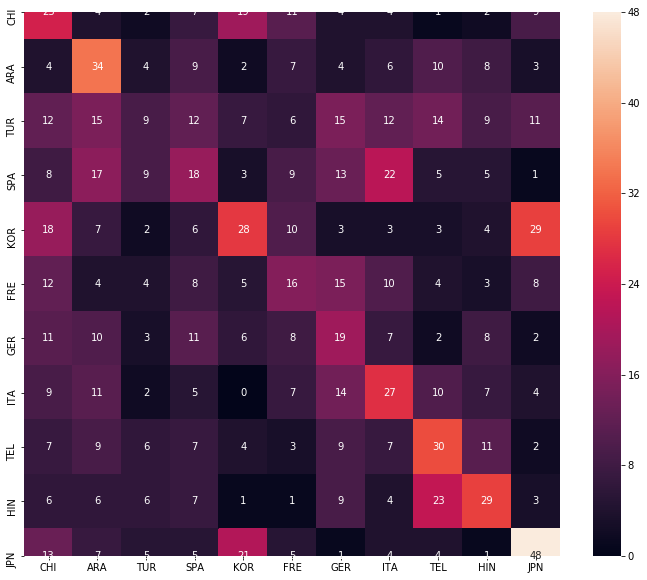

In [0]:
logisticRegression(train_1,train.lang,test_1,test.lang,"Sentence Part 1")

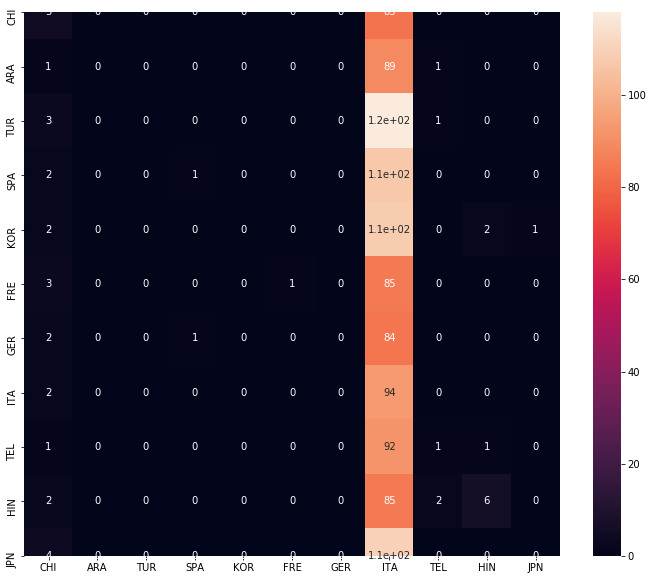

In [0]:
passiveAggressiveClassifier(train_1,train.lang,test_1,test.lang,"Sentence Part 1")

C:\Users\ghile\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ghile\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ghile\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ghile\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ghile\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

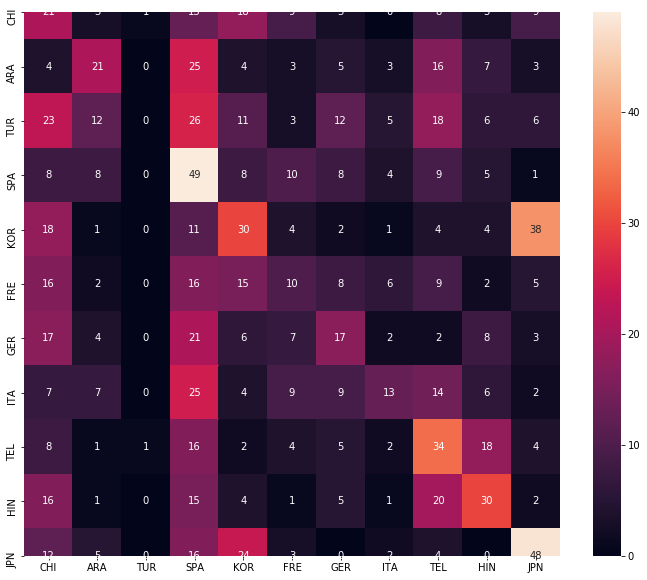

In [0]:
linearSVC(train_1,train.lang,test_1,test.lang,"Sentence Part 1")

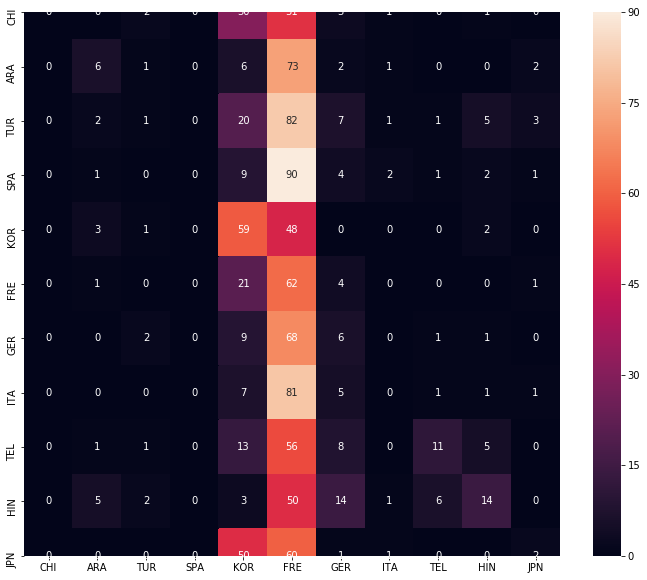

In [0]:
sGDClassifier(train_1,train.lang,test_1,test.lang,"Sentence Part 1")

# Sentence Part 2

In [0]:
# a- lengueur des textes par mots 
len_per_word = data.tokens.apply(len)
data.insert(len(data.columns),"len_per_word",len_per_word)

# b- lengueur des textes par phrase
len_per_sentence = data.sentences.apply(lambda x : len(x))
data.insert(len(data.columns),"len_per_sentence",len_per_sentence)

In [0]:
cols = ["CNT_punct","CNT_verb","CNT_adj","CNT_pron","CNT_nom","CNT_aux","CNT_cconj","CNT_det","CNT_adp","CNT_adv","CNT_intj","CNT_num","CNT_part","CNT_propn","CNT_sconj","CNT_sym","CNT_x"]

for col in cols :
    data[col+"_per_word"] = data[col] / data ["len_per_word"] 
    data[col+"_per_sent"] = data[col] / data ["len_per_sentence"]

In [0]:
# Calcul des 
lemma_total = len(reduce(lambda x,y : x.union(y),lemma_vocab))
vocab_total = len(reduce(lambda x,y : x.union(y),vocab))

lemma_vocab = data.tokens.apply(lambda x : set([x1[1] for x1 in x if x1[1] != "-PRON-"]))
data.insert(4,"lemma_vocab",lemma_vocab)

vocab = data.tokens.apply(lambda x : set([x1[0] for x1 in x]))
data.insert(4,"vocab",vocab)

lemma_vocab_count = lemma_vocab.apply(len)
data.insert(len(data.columns),"lemma_vocab_count",lemma_vocab_count)

vocab_count = vocab.apply(len)
data.insert(len(data.columns),"vocab_count",vocab_count)

diff_vocab_lemma = vocab.apply(len) - lemma_vocab.apply(len) 
data.insert(len(data.columns),"diff_vocab_lemma",diff_vocab_lemma)

fraq_vocab_lemma = lemma_vocab_count / vocab_count
data.insert(len(data.columns),"fraq_vocab_lemma",fraq_vocab_lemma)

total_fraq_lemma = lemma_vocab_count / lemma_total 
data.insert(len(data.columns),"total_fraq_lemma",total_fraq_lemma)

total_fraq_vocab = vocab_count / vocab_total
data.insert(len(data.columns),"total_fraq_vocab",total_fraq_vocab)

## Analyse des Shapes 

In [0]:
# shape des class
shapes = data.tokens.apply(lambda x : set([x1[-3] for x1 in x if x1[-3] not in [".",",",":",";",":","!","?","-","...","..","&","$","%","(",")","#","'","''","*","+","{","|","}","~","´"] ]))

In [0]:
# calculer le TF-IDF avec les shapes
from collections import Counter
col_shape  = reduce(lambda x,y: x.union(y),shapes)
l = list()
for shape in shapes: 
    s = Counter(shape)
    d = {x: 0 for x in col_shape}
    for k in s.keys():
        d[k] = s[k];
    l.append(d)

shapes = pd.DataFrame(l)

In [0]:
# calculer le TF-IDF avec les shapes
from collections import Counter
col_shape  = reduce(lambda x,y: x.union(y),shapes)
l = list()
for shape in shapes: 
    s = Counter(shape)
    d = {x: 0 for x in col_shape}
    for k in s.keys():
        d[k] = s[k];
    l.append(d)
    
shapes = pd.DataFrame(l)
shapes_count = shapes[shapes != 0].sum()
for i in shapes_count.index :
    shapes[i] = shapes[i] / shapes_count[i]

In [0]:
pd.concat([data,shapes],axis=1)

In [0]:
# teste les tf-idf avec les lemma 